# Downloading the dataset

The aim of this project is to classify urban noises. We are using the **urbansound8k** dataset, which contains more than **8000** audio samples in .wav format. Identifying city noises could be useful in several ways, for example:
*   Identifying gunshots to automatically dispatch police in the area
*   Identifying emergency vehicle sirens to automatically control traffic lights
*   Identifying dog barks or engine idling outside our home to notify that someone is coming

I've chosen this idea because in the past I already did projects related to audio classification (music genre classification), so I have some experience in this field already.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

In [ ]:
# Downloading the dataset from kaggle
path = kagglehub.dataset_download("chrisfilo/urbansound8k")

print("Path to dataset files:", path)

100%|██████████| 5.61G/5.61G [01:22<00:00, 72.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1


In [ ]:
# Loading metadata for audio files
metadata = pd.read_csv(path + "/UrbanSound8K.csv")
metadata.info()
metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


# Analyzing data

We will need the following metadata:
*   **slice_file_name** - name of the file
*   **fold** - the fold number (1-10) to which this file has been allocated.
*   **salience** - salience rating of the sound, 1 = foreground, 2 = background
*   **class** - name of the assigned class

We will drop other columns




In [ ]:
metadata = metadata.drop(columns=['fsID', 'start', 'end', 'classID'])
metadata.head()

,slice_file_name,salience,fold,class
0,100032-3-0-0.wav,1,5,dog_bark
1,100263-2-0-117.wav,1,5,children_playing
2,100263-2-0-121.wav,1,5,children_playing
3,100263-2-0-126.wav,1,5,children_playing
4,100263-2-0-137.wav,1,5,children_playing


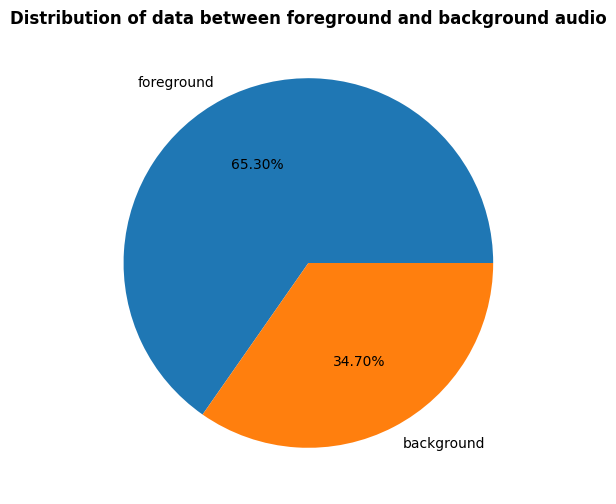

In [ ]:
# Distribution between foreground and background sounds
salience = metadata['salience'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(salience, labels=['foreground', 'background'], autopct='%.2f%%')
plt.title('Distribution of data between foreground and background audio', fontweight="bold")
plt.show()

Most of the data is for foreground noise. If we classified only using foreground noises, we could probably get better results because identifying  background noise is way harder.

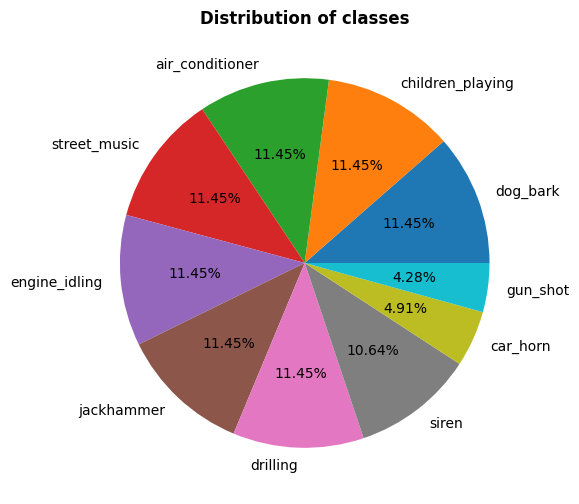

In [ ]:
# Let's create a pie chart to visualize the distribution of classes
classes = metadata['class'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(classes, labels=classes.index, autopct='%.2f%%')
plt.title('Distribution of classes', fontweight="bold")
plt.show()

The distribution of classes is mostly uniform, except for gunshots and car horn. This can cause the accuracy of prediction for gun_shot and car_horn classes to be lower, but in practice this didn't happen. Later we will use stratified split to preserve the original distribution of classes.

In [ ]:
# Loading one of the files to analyze as an example
example_data = metadata.iloc[0]
example_data_path = f"{path}/fold{example_data['fold']}/{example_data['slice_file_name']}"
print(example_data)

slice_file_name    100032-3-0-0.wav
salience                          1
fold                              5
class                      dog_bark
Name: 0, dtype: object


In [ ]:
import librosa
import IPython.display as ipd

ipd.Audio(example_data_path)

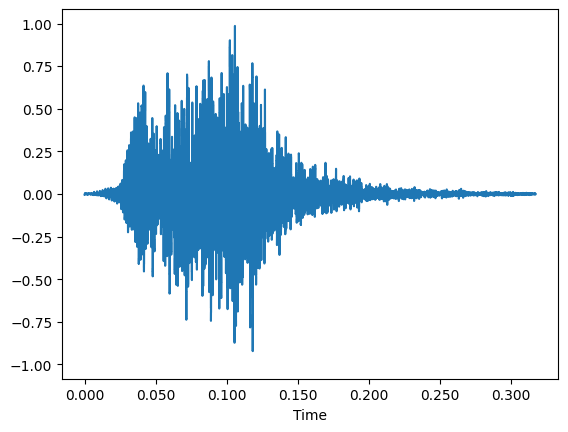

In [ ]:
# We use librosa to analyze audio files
audio, sample_rate = librosa.load(example_data_path)
librosa.display.waveshow(audio, sr = sample_rate)

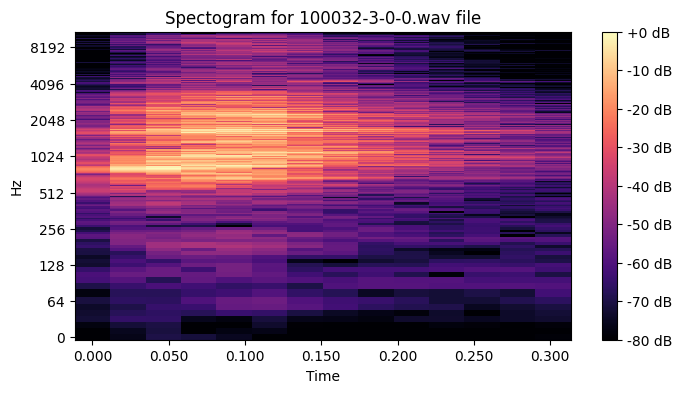

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(f"Spectogram for {example_data['slice_file_name']} file")
stft = np.abs(librosa.stft(audio))
img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),y_axis='log', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.0f dB")

This is a spectogram for one of the files in the dataset. Spectograms are created by applying a Short-time Fourier transform (STFT) to our audio.

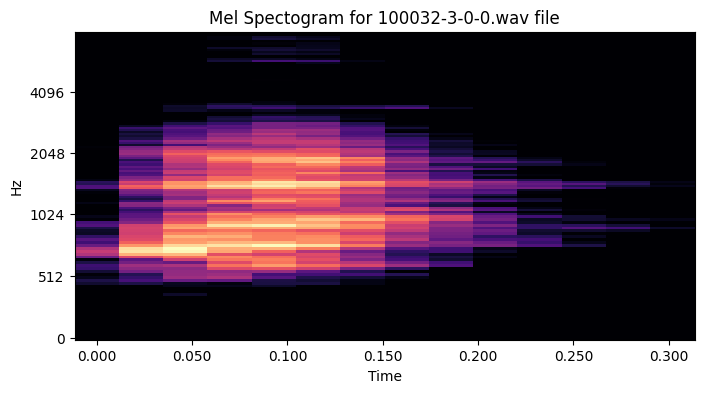

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(f"Mel Spectogram for {example_data['slice_file_name']} file")
mel_spectogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
img = librosa.display.specshow(librosa.amplitude_to_db(mel_spectogram, ref=np.max), x_axis='time',y_axis='mel', sr=sample_rate,fmax=8000, ax=ax)

This is a mel spectogram for the same file. Mel spectograms and Mel-frequency cepstral coefficients (mfcc) are very useful for speech recognition and audio classification problems. The process of obtaining these is quite complex, but the main idea is using a bank of Mel scale filters on the STFT of the audio file.

For this project, we will use mfcc's to classify audio, but in the 2nd project we could use images of mel spectograms as input for CNN.

In [ ]:
# Grouping data by classes
grouped_metadata = metadata.groupby('class')
num_classes = len(grouped_metadata)
print(num_classes)

10


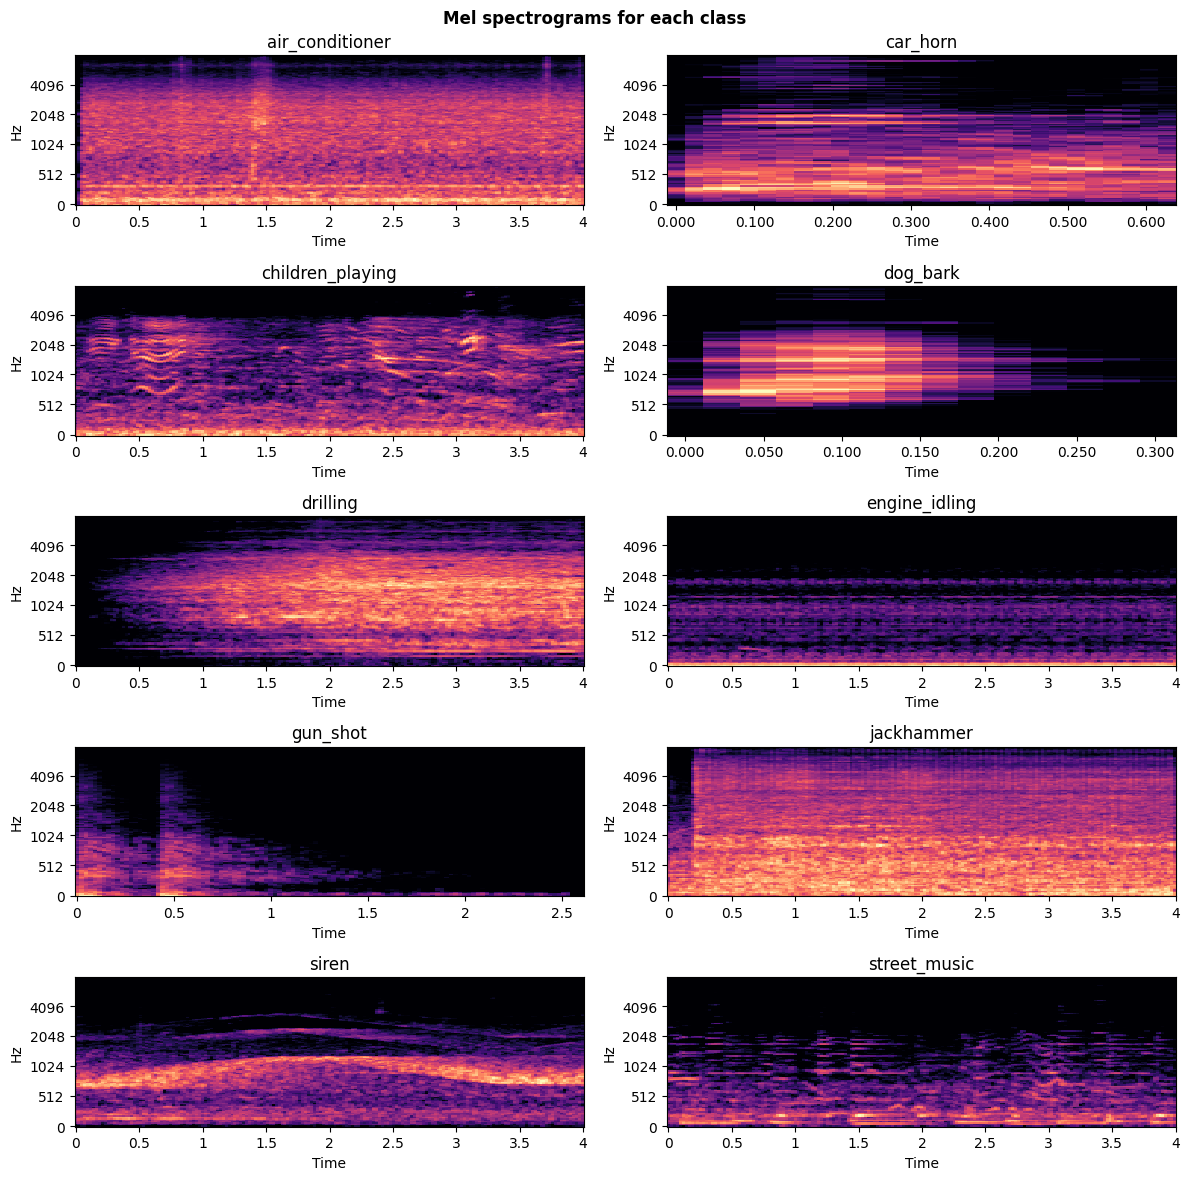

In [ ]:
# Visualize a mel spectogram for each class in our dataset
fig, axes = plt.subplots(5, 2, figsize=(12, 12))
fig.suptitle("Mel spectrograms for each class", fontweight="bold")
axes = axes.flatten()

for i, (class_name, group_data) in enumerate(grouped_metadata):
    data = group_data.iloc[0]
    data_path = f"{path}/fold{data['fold']}/{data['slice_file_name']}"
    audio, sample_rate = librosa.load(data_path)
    mel_spectogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    img = librosa.display.specshow(librosa.amplitude_to_db(mel_spectogram, ref=np.max), x_axis='time',y_axis='mel', sr=sample_rate,fmax=8000, ax=axes[i])
    axes[i].set_title(f"{class_name}")
fig.tight_layout()
plt.show()

We can see that each class has a distinctive looking mel spectogram. This means that we could use those as input for a CNN in the 2nd project.

# Feature extraction

In [ ]:
def extract_features(file):
    audio, sample_rate = librosa.load(file)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=25)
    features = np.mean(mfccs_features.T, axis=0)
    return features

For each audio sample in our dataset, we calculate Mel-frequency cepstral coefficients (mfcc). For this project we extract 25 coefficients.<br/>
Since for each coefficient we get results in time series format, as a feature we use the mean of the values over time. This is also necessary, because our audio samples are varying in length.

In [ ]:
from google.colab import drive

# First we check if we already have features extracted and saved on google drive, if not we extract features
drive.mount('/content/drive')
if os.path.isfile("/content/drive/My Drive/Colab Notebooks/UrbanSounds/data.csv"):
  data_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/UrbanSounds/data.csv")
  print("Loaded data.csv from google drive")
else:
  # Extracting features for each file in the dataset
  data = {
    'class': [],
    'features': []
  }
  for i in range(0, 10):
    files_path = f"{path}/fold{i+1}/"
    print(f"Feature extraction progress: {10*i}%")
    files = [f for f in os.listdir(files_path)]
    for file in files:
      file_path = os.path.join(files_path, file)
      file_class = metadata.loc[metadata['slice_file_name'] == file, 'class'].values[0]
      features = extract_features(file_path)
      data['class'].append(file_class)
      data['features'].append(features)
  # Saving results to google drive
  print("Feature extraction complete!")
  data_df = pd.DataFrame(data)
  features_list = data_df['features'].tolist()
  data_df = data_df.drop(columns=['features'])
  data_df = pd.concat([data_df, pd.DataFrame(features_list)], axis=1)
  data_df.to_csv(f"/content/drive/My Drive/Colab Notebooks/UrbanSounds/data.csv", index=False)
  print("Saved data.csv to google drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded data.csv from google drive


# Data preprocessing

We are splitting the data into an 80-10-10 split (80% for training, 10% for validation and 10% for final testing). We use StandardScaler to normalize data.
I've also tried other normalization methods but StandardScaler works best.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = data_df['class']
X = data_df.drop(columns=['class'])

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, shuffle=True)

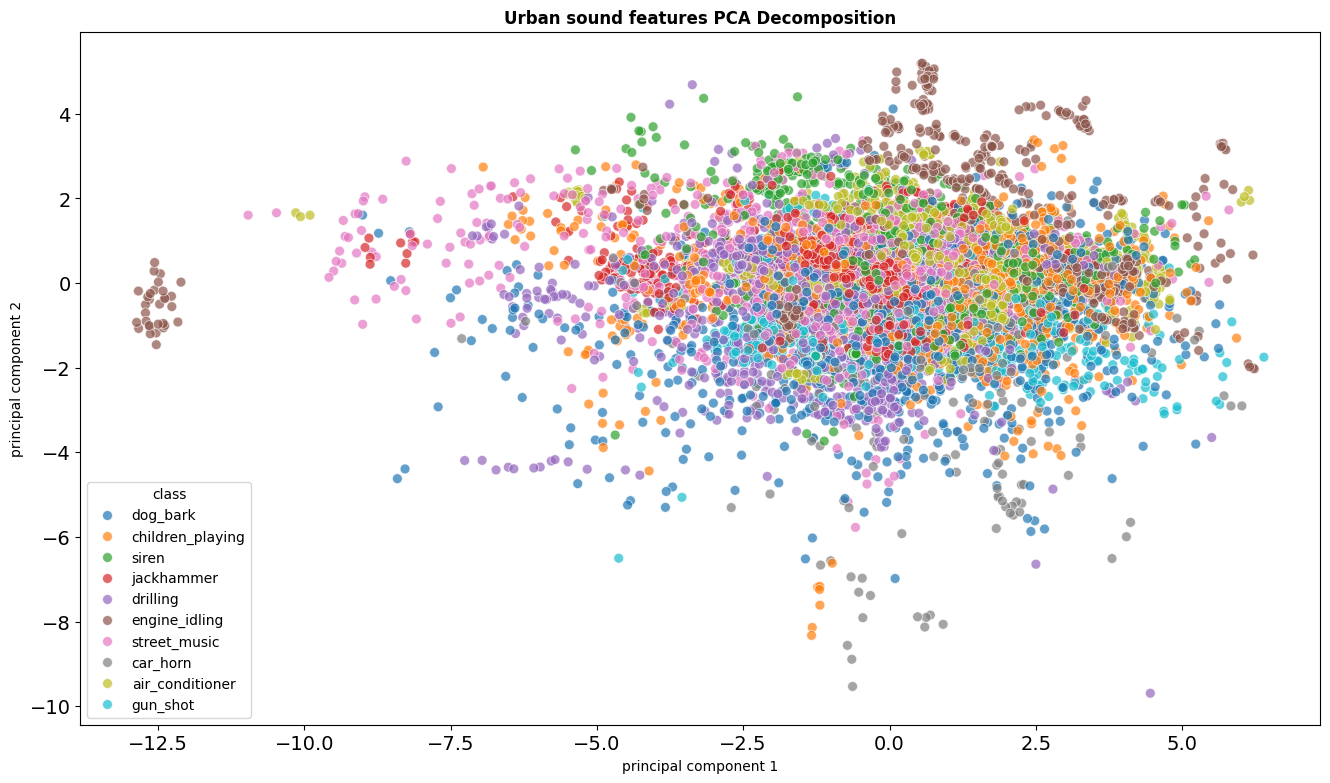

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# Let's use pca decomposition to visualize classes on a 2d plot
pca = PCA(n_components=2)
pca_components = pd.DataFrame(data = pca.fit_transform(X), columns = ["principal component 1", "principal component 2"])
pca_components = pd.concat([pca_components, pd.Series(y, name='class')], axis = 1)
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = pca_components, hue = "class", alpha = 0.7, s = 50)
plt.title("Urban sound features PCA Decomposition", fontweight = "bold")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

Using PCA decomposition we can visualize how our features correspond to different classes. This visualization is not very accurate though, because we are reducing from 25 to 2 dimensions. We can see that we have a few outliers in our data, which could potentially cause some problems.

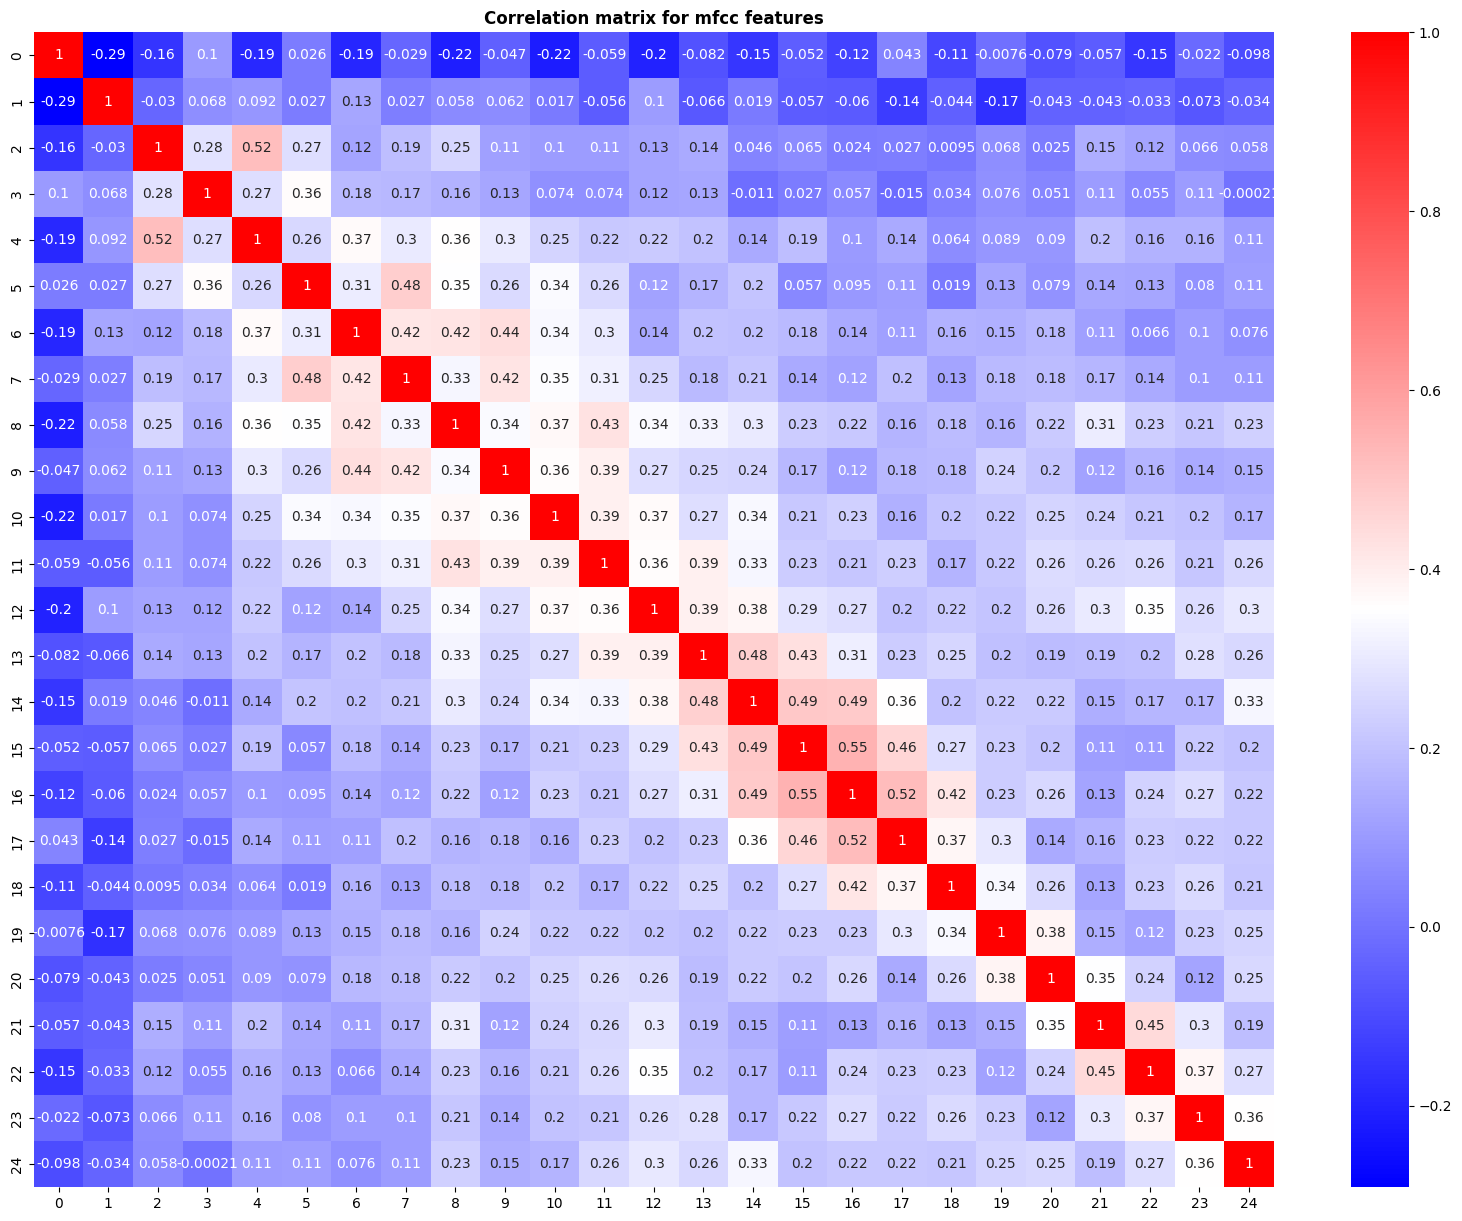

In [ ]:
# Now let's create a correlation matrix for some of the audio features to see how our features correlate to each other
correlation_matrix = pd.DataFrame(X).corr()
plt.figure(figsize = (20, 15))
sns.heatmap(correlation_matrix, cmap = "bwr", annot=True)
plt.title("Correlation matrix for mfcc features", fontweight = "bold")
plt.show()

We have some correlation for our features, but this is normal for mfcc features.

In [ ]:
# Encode classes
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_val = encoder.transform(np.array(y_val).reshape(-1, 1))

We use one hot encoding to encode our class labels.

# Build model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

num_features = X_train.shape[1]
print(f"Number of features: {num_features}")

Number of features: 25


In [ ]:
model = Sequential(
    [
        Input(shape=(num_features,)),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ]
)
classifier = tf.keras.models.clone_model(model)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │          13,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,826 (698.54 KB)

 Trainable params: 178,826 (698.54 KB)

 Non-trainable params: 0 (0.00 B)

For our neural network, I use **3** hidden layers with **512**, **256** and finally **128** neurons. The number of layers and neurons was chosen mostly through trial and error.
<br/><br/>
For the activation function in hidden layers, I use **ReLU**. This activation function is a standard for most modern applications of neural networks.<br/>
**ReLU** provides good results and efficient computation time while also reducing the risk of vanishing gradients.
<br/><br/>
For the output activation function, I use **softmax**, because we want to get values between (0, 1) that add up to 1, so we can classify sounds.
<br/><br/>
**Droput layers** are used after each dense layer to prevent overfitting of data, which is a possibility because a lot of sounds in our dataset are very similar and also because we have a lot of trainable parameters. By using dropout layers after each dense layer, we make our model less prone to memorization of the training data, which results in better generalization.
<br><br/>
For the optimizer, I use **adam**, because it provides best results and it's the most commonly used optimizer in modern neural network applications. Since we are dealing with a classification problem the for loss function we are using **categorical crossentropy**.

We train our model for **100 epochs**, but we use early stopping with a patience value of *10*. The patience value is high because we already use dropout to prevent overfitting, so we don't have to rely on early stopping as much.
For early stopping, we monitor validation accuracy.

In [ ]:
history = classifier.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=[X_val, y_val], callbacks=[early_stopping])

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3308 - loss: 1.9271 - val_accuracy: 0.6231 - val_loss: 1.1688
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6042 - loss: 1.1802 - val_accuracy: 0.7205 - val_loss: 0.9382
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6807 - loss: 0.9874 - val_accuracy: 0.7606 - val_loss: 0.7927
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7339 - loss: 0.8146 - val_accuracy: 0.7824 - val_loss: 0.6993
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7729 - loss: 0.7174 - val_accuracy: 0.8007 - val_loss: 0.6209
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8024 - loss: 0.6111 - val_accuracy: 0.8144 - val_loss: 0.5529
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8228 - loss: 0.5327 - val_accuracy: 0.8259 - val_loss: 0.5045
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8180 - loss: 0.5190 - val_accuracy: 0.8

# Evaluate model performance

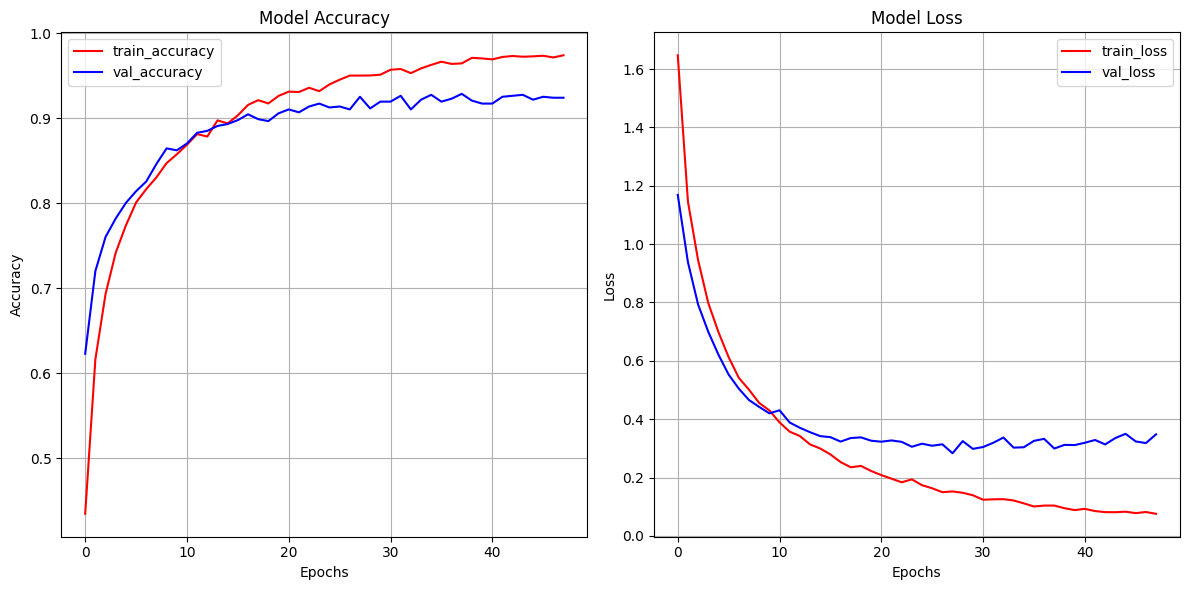

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Accuracy
axes[0].plot(history.history['accuracy'], color='red', label='train_accuracy')
axes[0].plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Model Accuracy')

# Plot Loss
axes[1].plot(history.history['loss'], color='red', label='train_loss')
axes[1].plot(history.history['val_loss'], color='blue', label='val_loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()
axes[1].set_title('Model Loss')

fig.tight_layout()
plt.show()

Plots show us how training and validation accuracy increases and loss decreases with each epoch.

In [ ]:
# Here we calculate test accuracy
predictions = classifier.predict(X_test)
y_pred = encoder.inverse_transform(predictions)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 90.50343249427918%


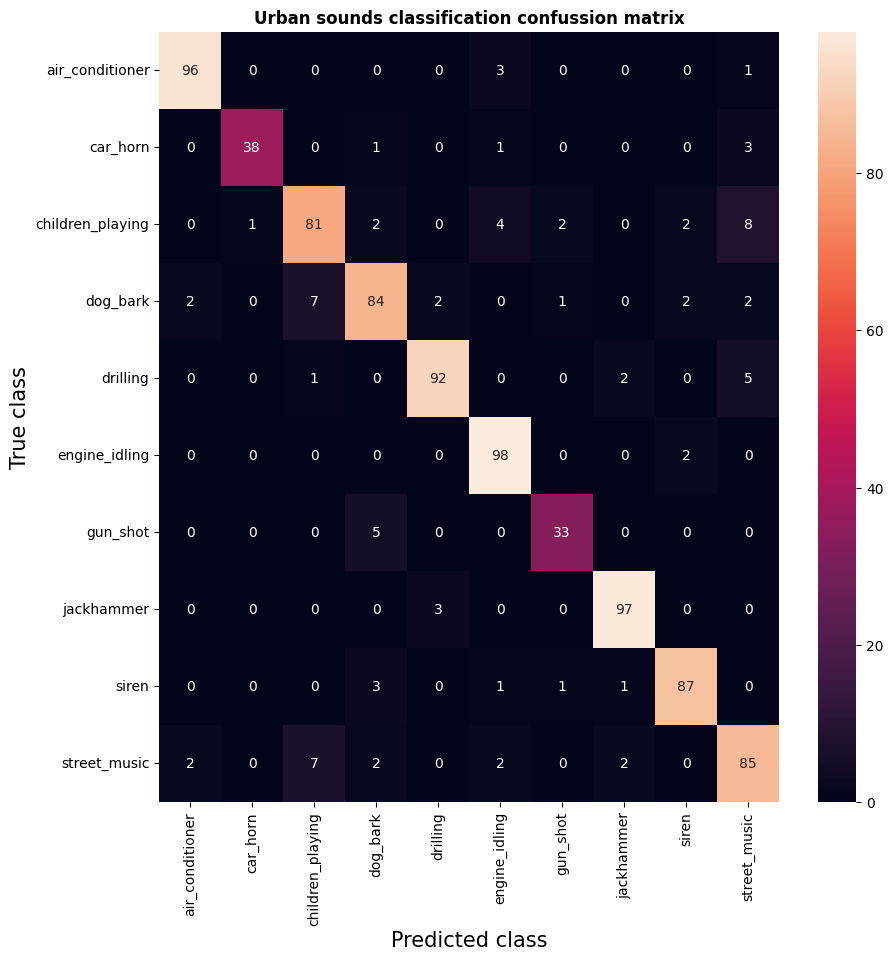

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (10, 10))
s = sns.heatmap(cm, annot=True, xticklabels = np.unique(y_test) , yticklabels = np.unique(y_test) , ax = ax, fmt='g')
s.set_xlabel("Predicted class", fontsize = 15)
s.set_ylabel("True class", fontsize = 15)
plt.title("Urban sounds classification confussion matrix", fontweight = "bold")
plt.show()

Confusion matrix shows our model's prediction performance for each class.

# Cross validation

In [ ]:
# Split X,y into 5 splits
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True)
split = kf.split(X, y)
accuracy_scores = []
for i, (train_index, test_index) in enumerate(split):
    print(f"Computing for Split {i+1}...")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)
    y_train = encoder.transform(np.array(y_train).reshape(-1, 1))
    y_val = encoder.transform(np.array(y_val).reshape(-1, 1))

    classifier = tf.keras.models.clone_model(model)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    classifier.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=[X_val, y_val], callbacks=[early_stopping], verbose=0)
    predictions = classifier.predict(X_test)
    y_pred = encoder.inverse_transform(predictions)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    print(f"Accuracy for Split {i+1}: {accuracy_scores[i]*100}%")

print(f"Average accuracy: {np.mean(accuracy_scores)*100}%")

Computing for Split 1...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy for Split 1: 92.21967963386729%
Computing for Split 2...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy for Split 2: 89.47368421052632%
Computing for Split 3...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy for Split 3: 92.43986254295532%
Computing for Split 4...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy for Split 4: 92.32531500572738%
Computing for Split 5...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy for Split 5: 91.17983963344788%
Average accuracy: 91.52767620530484%


We use cross validation to measure the overall performance of the model.

# Summary

**Summary of the project**:
*  The created model successfully managed to classify urban sounds with an average accuracy of **91.53%**
*  It is worth noting though that some audio samples in our dataset are very similar, so our performance may be a bit optimistic
*  In the future, we can make our task harder by splitting data into folds, where similar samples are separated, or try to classify separately for background and foreground noises
*  There is still room for improvement in our model. If we had more time, we could use **Grid Search** or **Bayesian Optimization** to find best values for parameters
*   For the 2nd project, we can try using Mel spectogram images as input to classify audio samples using CNN
*   Another idea for the future is to create a real-time audio classification system using our model




